In [42]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic data generation

In [44]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [45]:
import pandas as pd

In [46]:
# choice: 'basic', 'id'
synthesizer = 'id'

## Load transactions

In [47]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [48]:
if synthesizer == 'id':
    data = data[['account_id', 'type', 'operation', 'amount']]
else:
    data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
if synthesizer == 'id':
    data['account_id'] = data['account_id'].astype(dtype='int32')
    id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
    data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,account_id,type,operation,amount
0,0,1,2,700.0
1,0,1,2,7268.0
2,0,1,2,14440.0
3,0,1,2,49752.0
4,0,1,2,21899.0
5,0,0,3,34700.0
7,0,1,2,30192.0
8,0,0,0,9612.0
9,0,1,2,31038.0
10,0,0,3,25200.0


In [49]:
from sklearn.model_selection import train_test_split

In [50]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [51]:
if synthesizer == 'id':
    from synthesized.core import IdSynthesizer
    synthesizer = IdSynthesizer
elif synthesizer == 'basic':
    from synthesized.core import BasicSynthesizer
    synthesizer = BasicSynthesizer

In [52]:
with synthesizer(dtypes=data.dtypes) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

5000: 2.06e+08
10000: 1.15e+08
15000: 6.88e+07
20000: 6.37e+07
25000: 3.79e+07
30000: 4.67e+06
35000: 1.14e+06
40000: 7.21e+06
45000: 2.93e+06
50000: 3.09e+06


## Display synthesized data

In [53]:
synthesized.head(10)

,type,operation,amount,account_id
0,0,3,2519.430908,1469
1,0,3,2092.680420,1863
2,0,2,13737.649414,1519
3,0,3,4462.277832,2745
4,0,3,18501.621094,3750
5,0,3,433.244904,456
6,0,2,10849.892578,2286
7,0,3,8897.331055,741
8,1,3,16785.232422,1003
9,0,3,581.039001,611


# Visualization of original and synthetic data

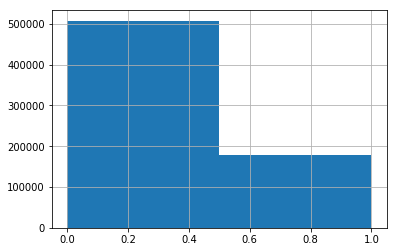

In [54]:
data['type'].hist(bins=2, range=[0, 1])

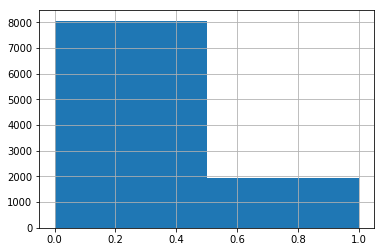

In [55]:
synthesized['type'].hist(bins=2, range=[0, 1])

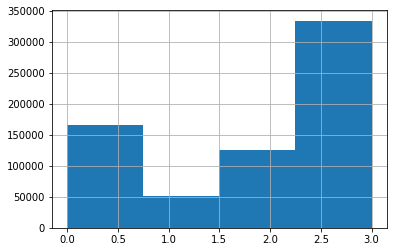

In [56]:
data['operation'].hist(bins=4, range=[0, 3])

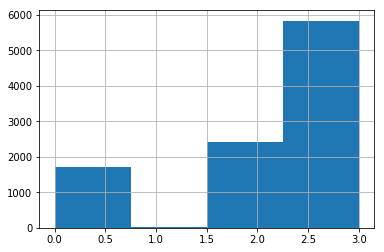

In [57]:
synthesized['operation'].hist(bins=4, range=[0, 3])

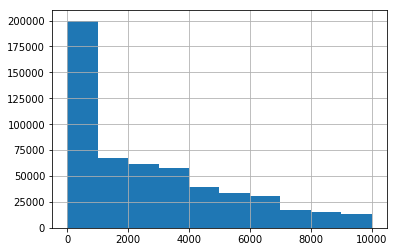

In [58]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

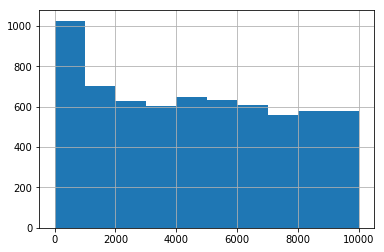

In [59]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [71]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [72]:
synthesized.head(5)

,type,operation,amount,account_id
0,0,3,2519.430908,1469
1,0,3,2092.680420,1863
2,0,2,13737.649414,1519
3,0,3,4462.277832,2745
4,0,3,18501.621094,3750


In [73]:
testing = Testing(data, test, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [74]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.199508,0.187276,8.100601e+07,8.224385e+07,0.938688,0.984949
1,amount (categorical reduction),DecisionTreeClassifier,0.757379,0.757379,0.687750,1.361495e+00,1.011126e+00,NaN,1.346514
2,operation,DecisionTreeClassifier,0.489277,0.976423,0.568210,8.923693e-02,2.525691e+00,0.162033,0.035332
3,type,DecisionTreeClassifier,0.741921,1.000000,0.827854,0.000000e+00,1.717608e-01,0.332971,0.000000


In [75]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.163693
1,"[21825.0, 43650.0)",0.284190
2,"[43650.0, 65475.0)",0.580544
3,"[65475.0, 87300.0)",inf


In [76]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.122571
1,"[8730.0, 17460.0)",0.101048
2,"[17460.0, 26190.0)",0.010739
3,"[26190.0, 34920.0)",0.159906
4,"[34920.0, 43650.0)",0.043694
5,"[43650.0, 52380.0)",0.192293
6,"[52380.0, 61110.0)",inf
7,"[61110.0, 69840.0)",inf
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf
